In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import os
import numpy as np
from PIL import Image
from xml.dom import minidom
from cairosvg import svg2png
import matplotlib.pyplot as plt

In [21]:
# create array of codes
codes = []
for i in range(1, 10):
    codes.append(f'MJt{i}')
    codes.append(f'MJs{i}')
    codes.append(f'MJw{i}')
for i in range(1, 5):
    codes.append(f'MJf{i}')
for i in range(1, 4):
    codes.append(f'MJd{i}')
for i in range(1, 9):
    codes.append(f'MJh{i}')
codes.sort()

In [3]:
# download images
errors = []
for code in tqdm(codes):
    url = f'https://commons.wikimedia.org/wiki/File:{code}-.svg'
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    # download as png
    # span = soup.find('span', {'class':'mw-filepage-other-resolutions'})
    # anchor = soup.find('a', string='843 × 1,024 pixels')
    # href = anchor.attrs['href']
    # download svg
    img = soup.find('img', {'alt': f'File:{code}-.svg'})
    anchor = img.parent
    href = anchor.attrs['href']
    path = f'./tiles/original_svg/{code}.svg'
    # set user agent header to bypass user-agent policy
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    response = requests.get(href, headers=headers)
    if 'Error' in response.text:
        errors.append(code)
    img_data = response.content
    with open(path, 'wb') as file:
        file.write(img_data)

100%|██████████| 42/42 [00:09<00:00,  4.60it/s]


In [4]:
# edit svg to remove some rectangles
base_svg_folder = './tiles/original_svg'
destination_svg_folder = './tiles/edit_svg'
for filename in os.listdir(base_svg_folder):
    doc = minidom.parse(os.path.join(base_svg_folder, filename))
    paths = doc.getElementsByTagName('path')
    for path in paths:
        if path.getAttribute('id') == 'rect4031':
            path.setAttribute('fill', '#ffffff')
    for path in paths:
        if path.getAttribute('id') == 'rect3008':
            path.parentNode.removeChild(path)
    with open(os.path.join(destination_svg_folder, filename), 'w') as file:
        file.write(doc.toxml())

In [5]:
svg_folder= './tiles/edit_svg'
dest_folder = './tiles/png_from_svg'
for filename in os.listdir(svg_folder):
    code = filename.split('.')[0]
    dest_filename = code + '.png'
    svg = minidom.parse(os.path.join(svg_folder, filename)).toxml()
    # clean string from illustrator references
    svg = svg.replace("<!ENTITY ns_extend \"http://ns.adobe.com/Extensibility/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_ai \"http://ns.adobe.com/AdobeIllustrator/10.0/\">", "")
    svg = svg.replace("<!ENTITY ns_graphs \"http://ns.adobe.com/Graphs/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_vars \"http://ns.adobe.com/Variables/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_imrep \"http://ns.adobe.com/ImageReplacement/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_sfw \"http://ns.adobe.com/SaveForWeb/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_custom \"http://ns.adobe.com/GenericCustomNamespace/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_adobe_xpath \"http://ns.adobe.com/XPath/1.0/\">", "")
    svg2png(bytestring=svg, write_to=os.path.join(dest_folder, dest_filename), output_width=834, output_height=1024)

In [6]:
# crop each image to have only main rectangle
top_left = (53,211)
dimensions = (600, 760)
left = top_left[0]
right = left + dimensions[0]
top = top_left[1]
bottom = top + dimensions[1]
base_folder = './tiles/png_from_svg'
destination_folder = './tiles/edit'
for filename in os.listdir(base_folder):
    image = Image.open(os.path.join(base_folder, filename))
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(os.path.join(destination_folder, filename))

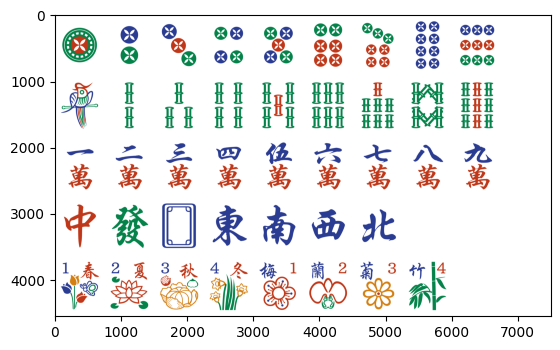

In [50]:
# create final overall image
image = Image.new('RGB', (10*(dimensions[0]+150), 5*(dimensions[1]+150)), color=(255,255,255))
distribution = [[code for code in codes if 't' in code]]
distribution[0].sort()
distribution.append([code for code in codes if 's' in code])
distribution[1].sort()
distribution.append([code for code in codes if 'w' in code])
distribution[2].sort()
distribution.append([code for code in codes if 'f' in code or 'd' in code])
distribution[3].sort()
distribution.append([code for code in codes if 'h' in code])
distribution[4].sort()
for i, code_list in enumerate(distribution):
    for j, code in enumerate(code_list):
        tile = Image.open(os.path.join(destination_folder, code + '.png'))
        image.paste(tile, (j*(dimensions[0]+150)+75,i*(dimensions[1]+150)+75))
plt.imshow(image);
image.save('./tiles/tiles_white.png')

In [19]:
# create dark images
src_folder = './tiles/edit_svg'
dst_folder = './tiles/edit_svg_dark'
os.makedirs(dst_folder, exist_ok=True)
for filename in os.listdir(src_folder):
    doc = minidom.parse(os.path.join(src_folder, filename))
    xml = doc.toxml()
    # replace colors
    xml = xml.replace('FFFFFF', '1e1e1e')
    xml = xml.replace('ffffff', '1e1e1e')
    xml = xml.replace('fff', '1e1e1e')
    xml = xml.replace('038249', 'FFFFFF')
    xml = xml.replace('BF3718', 'F0A023')
    xml = xml.replace('bf3718', 'F0A023')
    xml = xml.replace('2A3B92', '56A3A6')
    xml = xml.replace('2a3b92', '56A3A6')
    xml = xml.replace('D37F11', 'D35269')
    xml = xml.replace('d37f11', 'D35269')
    with open(os.path.join(dst_folder, filename), 'w') as file:
        file.write(xml)
# convert svg to png
src_folder = dst_folder
dst_folder = './tiles/png_from_svg_dark'
os.makedirs(dst_folder, exist_ok=True)
for filename in os.listdir(src_folder):
    dst_filename = filename.split('.')[0] + '.png'
    svg = minidom.parse(os.path.join(src_folder, filename)).toxml()
    # clean string from illustrator references
    svg = svg.replace("<!ENTITY ns_extend \"http://ns.adobe.com/Extensibility/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_ai \"http://ns.adobe.com/AdobeIllustrator/10.0/\">", "")
    svg = svg.replace("<!ENTITY ns_graphs \"http://ns.adobe.com/Graphs/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_vars \"http://ns.adobe.com/Variables/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_imrep \"http://ns.adobe.com/ImageReplacement/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_sfw \"http://ns.adobe.com/SaveForWeb/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_custom \"http://ns.adobe.com/GenericCustomNamespace/1.0/\">", "")
    svg = svg.replace("<!ENTITY ns_adobe_xpath \"http://ns.adobe.com/XPath/1.0/\">", "")
    svg2png(bytestring=svg, write_to=os.path.join(dst_folder, dst_filename), output_width=834, output_height=1024)
# crop each image to have only main rectangle
top_left = (53, 211)
dimensions = (600, 760)
left = top_left[0]
right = left + dimensions[0]
top = top_left[1]
bottom = top + dimensions[1]
src_folder = dst_folder
dst_folder = './tiles/edit_dark'
os.makedirs(dst_folder, exist_ok=True)
for filename in os.listdir(src_folder):
    image = Image.open(os.path.join(src_folder, filename))
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(os.path.join(dst_folder, filename))

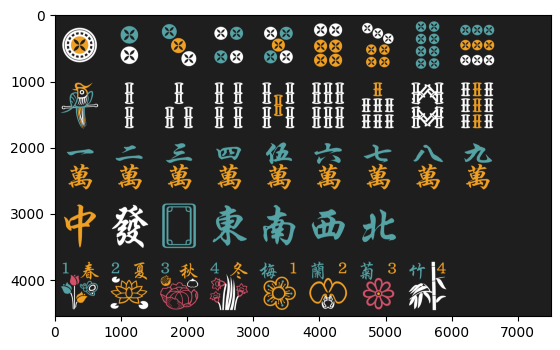

In [22]:
# create final overall image
image = Image.new('RGB', (10*(dimensions[0]+150), 5*(dimensions[1]+150)), color=(30,30,30))
distribution = [[code for code in codes if 't' in code]]
distribution[0].sort()
distribution.append([code for code in codes if 's' in code])
distribution[1].sort()
distribution.append([code for code in codes if 'w' in code])
distribution[2].sort()
distribution.append([code for code in codes if 'f' in code or 'd' in code])
distribution[3].sort()
distribution.append([code for code in codes if 'h' in code])
distribution[4].sort()
for i, code_list in enumerate(distribution):
    for j, code in enumerate(code_list):
        tile = Image.open(os.path.join(dst_folder, code + '.png'))
        image.paste(tile, (j*(dimensions[0]+150)+75,i*(dimensions[1]+150)+75))
plt.imshow(image);
image.save('./tiles/tiles_dark.png')